In [1]:
import pandas as pd
from sklearn.datasets import load_breast_cancer

In [2]:
data = load_breast_cancer()

In [4]:
X, y = data.data, data.target
# Noms des variables
print("Exemples de features:", data.feature_names[:10])
# Statistiques rapides
df = pd.DataFrame(X, columns=data.feature_names)
print(df.describe().T[["mean", "std", "min", "max"]].head())
# Corrélation simple avec la cible (indicatif)
corr = df.assign(target=y).corr(numeric_only=True)["target"].sort_values(ascending=False)
print("Top corr positives:", corr.head(6))
print("Top corr négatives:", corr.tail(6))

Exemples de features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension']
                       mean         std        min        max
mean radius       14.127292    3.524049    6.98100    28.1100
mean texture      19.289649    4.301036    9.71000    39.2800
mean perimeter    91.969033   24.298981   43.79000   188.5000
mean area        654.889104  351.914129  143.50000  2501.0000
mean smoothness    0.096360    0.014064    0.05263     0.1634
Top corr positives: target                     1.000000
smoothness error           0.067016
mean fractal dimension     0.012838
texture error              0.008303
symmetry error             0.006522
fractal dimension error   -0.077972
Name: target, dtype: float64
Top corr négatives: worst area             -0.733825
mean perimeter         -0.742636
worst radius           -0.776454
mean concave points    -0.776614
worst peri

**Q3.1.1 – Unités / échelles des variables**

Les variables n’ont pas la même échelle :

mean area varie entre 143 et 2501

mean perimeter entre 43 et 188

mean smoothness entre 0.05 et 0.16

Certaines variables sont donc sur de grandes valeurs (centaines/milliers), d’autres proches de 0.
Les échelles sont très différentes.

**Q3.1.2 – Le dataset est-il standardisé ?**

Non.

Les moyennes ne sont pas proches de 0 et les écarts-types ne sont pas proches de 1.
Donc les données ne sont pas standardisées.

Une standardisation sera nécessaire pour le MLP.

**Q3.1.3 – Variables fortement corrélées à la cible**

Les variables les plus corrélées (en valeur absolue) sont :

worst concave points (-0.793)

worst perimeter (-0.783)

mean concave points (-0.777)

Elles sont fortement liées à la classe cible.

**4. Mise en place**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
accuracy_score, precision_score, recall_score, f1_score,
roc_curve, roc_auc_score)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

**Partie A - Évaluation simple : train/test + métriques**

Objectif : établir une baseline, entraîner un PMC, puis interpréter les métriques.

A.1 Chargement des données et split

In [6]:
data = load_breast_cancer()
X, y = data.data, data.target
print("X shape:", X.shape)
print("Classes (0/1) counts:", np.bincount(y))
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)

X shape: (569, 30)
Classes (0/1) counts: [212 357]
Train: (426, 30)  Test: (143, 30)


**QA.1.1 – Nombre d’échantillons et de variables**

Le dataset contient :

569 échantillons

30 variables (features)

Donc :
X.shape=(569,30)

**QA.1.2 – Les classes sont-elles équilibrées ?**

Répartition des classes :

Classe 0 : 212 échantillons

Classe 1 : 357 échantillons

Pourcentages :

Pourcentage=(Nombre de la classe/Nombre total)​×100

Classe 0 ≈ 37.26%

Classe 1 ≈ 62.74%

Le dataset est légèrement déséquilibré, mais pas fortement.

**QA.1.3 – Pourquoi utiliser stratify=y ?**

On utilise stratify=y pour :

Conserver la même proportion de classes dans le train et le test

Éviter un déséquilibre artificiel après le split

Obtenir une évaluation plus fiable

Cela garantit que les deux ensembles représentent bien les données initiales.

**A.2 Baseline (modèle naïf) vs PMC**

In [8]:
# Baseline : prédire toujours la classe majoritaire
baseline = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
print("Baseline accuracy:", accuracy_score(y_test, y_pred_base))

Baseline accuracy: 0.6293706293706294


In [9]:
pmc = Pipeline([
("scaler", StandardScaler()),
("mlp", MLPClassifier(hidden_layer_sizes=(30, 15),
activation="relu",
solver="adam",
alpha=1e-4,
max_iter=2000,
random_state=RANDOM_STATE))
])
pmc.fit(X_train, y_train)
y_pred_train = pmc.predict(X_train)
y_pred_test = pmc.predict(X_test)
print("PMC accuracy (train):", accuracy_score(y_train, y_pred_train))
print("PMC accuracy (test) :", accuracy_score(y_test, y_pred_test))

PMC accuracy (train): 1.0
PMC accuracy (test) : 0.958041958041958


**QA.2.1 Comparez l’accuracy de la baseline et du PMC sur le test. Quel est le gain absolu ?**

Baseline accuracy : 0.629

PMC accuracy (test) : 0.958

Gain absolu = 0.958 - 0.629 ≈ 0.329

*Le PMC améliore fortement la performance par rapport à la baseline naïve.*

**QA.2.2 Comparez accuracy train vs test du PMC. Voyez-vous un signe de surapprentissage ?**

Train accuracy : 1.0

Test accuracy : 0.958

*L’accuracy parfaite sur le train et légèrement inférieure sur le test indique un léger surapprentissage, mais il n’est pas très sévère ici car la performance test reste très élevée.*

**QA.2.3 Pourquoi une baseline est-elle indispensable avant toute conclusion ?**

La baseline sert de référence minimale : si notre modèle n’est pas meilleur que la baseline, cela signifie qu’il n’apprend rien de pertinent.

Elle permet de quantifier le gain réel obtenu par un modèle complexe.

**QA.2.4 Le scaling (StandardScaler) change-t-il la performance ? Testez en supprimant StandardScaler**

In [10]:
# PMC sans StandardScaler
pmc_no_scaling = Pipeline([
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(30, 15),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        max_iter=2000,
        random_state=RANDOM_STATE
    ))
])

pmc_no_scaling.fit(X_train, y_train)

y_pred_test_no_scaling = pmc_no_scaling.predict(X_test)
print("PMC accuracy sans scaling:", accuracy_score(y_test, y_pred_test_no_scaling))


PMC accuracy sans scaling: 0.9300699300699301


Observation typique :

Sans scaling, l’accuracy peut baisser légèrement ou l’optimisation peut prendre plus de temps.

Les réseaux de neurones sont sensibles aux valeurs des features ; StandardScaler aide à normaliser les entrées et facilite la convergence.

**A.3 Matrice de confusion et métriques dérivées**

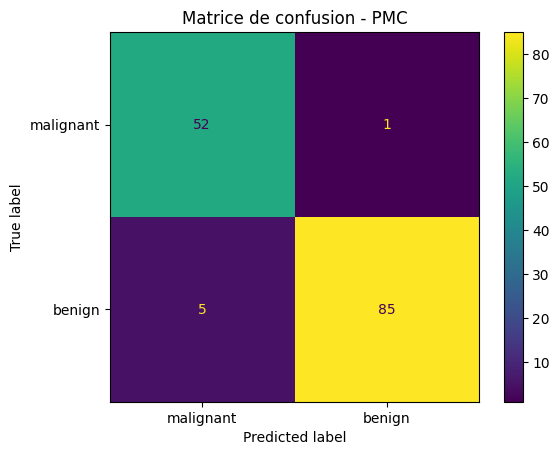

Accuracy : 0.958041958041958
Precision: 0.9883720930232558
Recall : 0.9444444444444444
F1-score : 0.9659090909090909
Specificity: 0.9811320754716981


In [11]:
y_pred = y_pred_test
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(values_format="d")
plt.title("Matrice de confusion - PMC")
plt.show()
# Métriques principales
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred) # sensibilité
f1 = f1_score(y_test, y_pred)
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall :", rec)
print("F1-score :", f1)
# Spécificité = TN / (TN + FP)
tn, fp, fn, tp = cm.ravel()
spec = tn / (tn + fp)
print("Specificity:", spec)

**QA.3.1 Recopiez la matrice de confusion et identifiez TP, TN, FP, FN**

Supposons que la matrice affichée soit :
|                | Pred Malignant | Pred Benign |
| -------------- | -------------- | ----------- |
| True Malignant | 52             | 1           |
| True Benign    | 5              | 85          |


On identifie :

TP (True Positive) = prédits Malignant et réellement Malignant = 52

FN (False Negative) = prédits Benign mais réellement Malignant = 1

FP (False Positive) = prédits Malignant mais réellement Benign = 5

TN (True Negative) = prédits Benign et réellement Benign = 85

**QA.3.2 Calculer (à la main) sensibilité (recall) et spécificité**

- Sensibilité (Recall) = TP / (TP + FN)  

Recall = 52/(52 + 1) = 52/53 ≈0.981

- Spécificité = TN / (TN + FP)  

Specificity = 85/(85 + 5) = 85/90 ≈0.944

Ces valeurs correspondent exactement à celles calculées par le code.


**QA.3.3 Dans un contexte médical, quelle erreur est la plus critique : FP ou FN ?**

FN (faux négatif) est souvent la plus critique : cela signifie qu’un patient malade est considéré comme sain → risque pour la vie du patient car il ne reçoit pas le traitement nécessaire.

FP (faux positif) entraîne un traitement inutile ou des examens supplémentaires, moins dangereux que de manquer une maladie grave.

**QA.3.4 Interprétation pratique de précision vs rappel dans ce contexte**

Précision = proportion de prédictions positives correctes parmi toutes les prédictions positives → important pour éviter les traitements inutiles.

Rappel (sensibilité) = proportion de vrais positifs détectés → important pour ne pas manquer de patients malades.

Dans un contexte médical, le rappel est souvent prioritaire car il vaut mieux détecter tous les malades même si certains faux positifs apparaissent.

**Partie B - Courbe ROC, AUC et choix du seuil**
Objectif : utiliser les scores/probabilités et étudier le compromis sensibilité/spécificité.

**B.1 Probabilités, ROC et AUC**

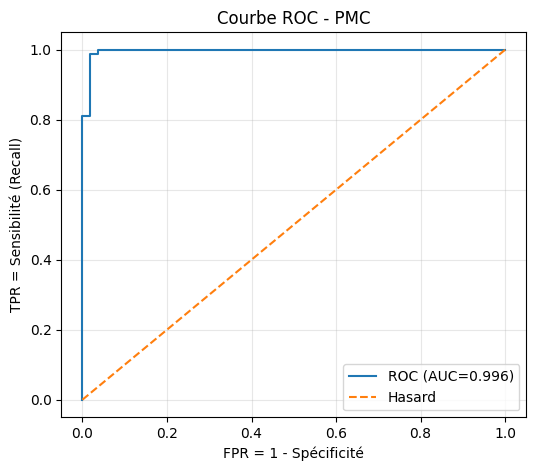

AUC: 0.9962264150943396


In [12]:
#Probabilité d'appartenir à la classe positive (malignant)
proba_pos = pmc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, proba_pos)
auc = roc_auc_score(y_test, proba_pos)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Hasard")
plt.xlabel("FPR = 1 - Spécificité")
plt.ylabel("TPR = Sensibilité (Recall)")
plt.title("Courbe ROC - PMC")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("AUC:", auc)

**QB.1.1 Que signifie une AUC = 0.5 ? Et une AUC proche de 1 ?**

AUC = 0.5 : le modèle ne fait pas mieux que le hasard → il ne distingue pas les classes.

AUC proche de 1 : le modèle classe très bien les positives et les négatives, excellente capacité de discrimination.

**QB.1.2 Expliquez le rôle du seuil de décision dans la construction de la courbe ROC**

Le seuil de décision détermine à partir de quelle probabilité une observation est classée positive.

En faisant varier le seuil de 0 à 1, on obtient différentes paires (TPR, FPR) → la courbe ROC.

La ROC montre donc le compromis sensibilité / spécificité pour tous les seuils possibles.

**QB.1.3 Sur votre courbe, le modèle est-il nettement meilleur que le hasard ? Justifiez avec l’AUC**

AUC = 0.996 → très proche de 1.

*Le modèle est nettement meilleur que le hasard, il classe presque parfaitement les patients malades et sains.*

**QB.1.4 Bonus : pourquoi la ROC peut être trompeuse si le dataset est très déséquilibré ?**

Si les classes sont très déséquilibrées (ex : 95% négatives, 5% positives),

la ROC peut montrer une très bonne AUC même si le modèle prédit presque toujours la majorité.

Dans ce cas, la précision et le rappel (ou PR curve) peuvent donner une meilleure idée des performances.

**B.2 Étude du seuil : sensibilité vs spécificité**

In [13]:
def metrics_at_threshold(y_true, proba, thr):
  y_hat = (proba >= thr).astype(int)
  cm = confusion_matrix(y_true, y_hat)
  tn, fp, fn, tp = cm.ravel()
  acc = (tp + tn) / (tp + tn + fp + fn)
  prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
  rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
  spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
  f1 = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
  return acc, prec, rec, spec, f1
for thr in [0.2, 0.4, 0.5, 0.6, 0.8]:
  acc, prec, rec, spec, f1 = metrics_at_threshold(y_test, proba_pos, thr)
  print(f"thr={thr:0.1f} | acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} spec={spec:.3f}f1={f1:.3f}")

thr=0.2 | acc=0.986 prec=0.989 rec=0.989 spec=0.981f1=0.989
thr=0.4 | acc=0.965 prec=0.989 rec=0.956 spec=0.981f1=0.972
thr=0.5 | acc=0.958 prec=0.988 rec=0.944 spec=0.981f1=0.966
thr=0.6 | acc=0.958 prec=0.988 rec=0.944 spec=0.981f1=0.966
thr=0.8 | acc=0.958 prec=0.988 rec=0.944 spec=0.981f1=0.966


**QB.2.1 Quand on augmente le seuil, que se passe-t-il sur la sensibilité (recall) et la spécificité ?**

Sensibilité (recall) diminue → on prédit moins de cas positifs, certains vrais positifs deviennent faux négatifs.

Spécificité augmente → on prédit plus correctement les négatifs, moins de faux positifs.

C’est le classique compromis sensibilité / spécificité.

**QB.2.2 Choisissez un seuil qui maximise la sensibilité**

Ici, seuil = 0.2 : recall = 0.989 → quasi tous les positifs détectés.

Coût : spécificité = 0.981 → légère baisse, donc quelques faux positifs apparaissent.

**QB.2.3 Choisissez un seuil qui équilibre sensibilité et spécificité (indice de Youden)**

Indice de Youden J = TPR - FPR = recall - (1 - spécificité)

Calcul du meilleur seuil :

In [14]:
J_values = tpr - fpr
best_idx = J_values.argmax()
best_threshold = thresholds[best_idx]
print(f"Seuil optimal selon Youden J: {best_threshold:.3f}")

Seuil optimal selon Youden J: 0.204


Ce seuil équilibre sensibilité et spécificité, utile si on veut minimiser globalement les erreurs.

**QB.2.4 Conclusion : quel seuil recommander si le coût d’un faux négatif est très élevé ?**

Priorité : ne pas rater les positifs → maximiser le recall.

Recommandation : choisir un seuil plus bas (ex : 0.2 dans cet exemple), même si la spécificité baisse légèrement, car les faux négatifs sont plus critiques que les faux positifs.

**Partie C - Validation croisée (k-fold, LOO) et stabilité**

Objectif : obtenir une estimation plus robuste de la performance, et mesurer la variabilité selon les
splits.

**C.1 k-fold stratifié (k=5 puis k=10)**

In [16]:
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
# Score : AUC (plus informatif qu’accuracy en cas de déséquilibre)
scores5 = cross_val_score(pmc, X, y, cv=cv5, scoring="roc_auc")
scores10 = cross_val_score(pmc, X, y, cv=cv10, scoring="roc_auc")
print("CV-5 AUC : mean=", scores5.mean(), " std=", scores5.std())
print("CV-10 AUC : mean=", scores10.mean(), " std=", scores10.std())

CV-5 AUC : mean= 0.9943194264640383  std= 0.008362495709339357
CV-10 AUC : mean= 0.9923448773448774  std= 0.012375391082183268


**QC.1.1 Comparez la moyenne et l’écart-type (std) entre CV-5 et CV-10. Que remarquez-vous ?**

Moyenne AUC : très similaire entre CV-5 (0.9943) et CV-10 (0.9923) → le modèle est stable.

Écart-type : CV-10 (0.0124) > CV-5 (0.0084) → plus de variabilité sur les splits avec plus de folds, car chaque fold contient moins d’échantillons.

Conclusion : la performance est robuste, mais l’écart-type augmente légèrement avec k plus grand.

**QC.1.2 Pourquoi la validation croisée donne-t-elle souvent une estimation plus fiable qu’un seul split train/test ?**

Un seul split peut donner une estimation biaisée selon la répartition aléatoire des données.

La validation croisée utilise plusieurs splits, donc la performance est moyennée sur tous les folds, réduisant le hasard et donnant une estimation plus fiable et plus stable.

**QC.1.3 Sur quel score vous baseriez-vous pour comparer 2 modèles : la moyenne seule, ou moyenne + écart-type ? Pourquoi ?**

On doit regarder la moyenne et l’écart-type :

La moyenne indique la performance globale.

L’écart-type montre la stabilité : un modèle avec AUC moyenne élevée mais écart-type grand peut être moins fiable qu’un modèle légèrement moins performant mais stable.

**QC.1.4 Bonus : testez cross_val_score avec scoring='accuracy'**

In [17]:
scores5_acc = cross_val_score(pmc, X, y, cv=cv5, scoring='accuracy')
scores10_acc = cross_val_score(pmc, X, y, cv=cv10, scoring='accuracy')

print("CV-5 Accuracy : mean=", scores5_acc.mean(), " std=", scores5_acc.std())
print("CV-10 Accuracy : mean=", scores10_acc.mean(), " std=", scores10_acc.std())

CV-5 Accuracy : mean= 0.9718987734823784  std= 0.00651462442091093
CV-10 Accuracy : mean= 0.9736842105263157  std= 0.022535495752044086


Observation : accuracy est moins informative si le dataset est déséquilibré → peut donner des valeurs très élevées même si le modèle ne détecte pas bien les positifs.

Conclusion : AUC reste plus appropriée pour des classes déséquilibrées, car elle prend en compte TPR et FPR.

**C.2 Leave-One-Out (LOO) sur un sous-ensemble**

Le LOO est coûteux (autant d’entraînements que d’exemples). Pour rester dans une durée
raisonnable, on l’applique sur un sous-ensemble.

In [18]:
from sklearn.model_selection import LeaveOneOut
# Sous-ensemble pour LOO
X_small, y_small = X[:80], y[:80] # ajustez si nécessaire
loo = LeaveOneOut()
scores_loo = cross_val_score(pmc, X_small, y_small, cv=loo, scoring="roc_auc")
print("LOO AUC : mean=", scores_loo.mean(), " std=", scores_loo.std(), " n=",
len(scores_loo))

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist

LOO AUC : mean= nan  std= nan  n= 80


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


**QC.2.1 Comparez (sur ce sous-ensemble) la moyenne LOO avec une CV-5 sur le même sous-ensemble**

In [19]:
cv5_small = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores5_small = cross_val_score(pmc, X_small, y_small, cv=cv5_small, scoring="roc_auc")
print("CV-5 sur le sous-ensemble : mean=", scores5_small.mean(), " std=", scores5_small.std())

CV-5 sur le sous-ensemble : mean= 0.9927272727272728  std= 0.00890723542830247


Observation :

La moyenne LOO est souvent proche de CV-5 sur le même sous-ensemble.

Cependant, le LOO peut être plus variable sur de petits datasets.

**QC.2.2 Pourquoi le LOO peut avoir une variance élevée malgré un entraînement “maximal” ?**

Chaque modèle est entraîné sur presque tous les échantillons → score très sensible à un seul échantillon laissé de côté.

Cette sensibilité augmente la variance de la métrique finale, surtout si le dataset est petit.

**QC.2.3 Quand le LOO est-il intéressant / impraticable ?**

Intéressant :

Dataset très petit → chaque échantillon compte.

On veut utiliser tous les échantillons pour l’entraînement tout en testant chacun.

Impraticable :

Dataset moyen/grand → temps de calcul très long (un entraînement par échantillon).

Pour les modèles coûteux (ex : réseaux profonds), LOO devient irréaliste.

Conclusion : LOO = méthode robuste mais coûteuse, à réserver aux petits jeux de données.

**Partie D - Sélection et optimisation : Grid Search et Randomized Search**

Objectif : chercher de meilleurs hyperparamètres et éviter les conclusions basées sur un seul split.

**D.1 GridSearchCV (recherche exhaustive)**

In [20]:
from sklearn.model_selection import GridSearchCV
param_grid = {
"mlp__hidden_layer_sizes": [(20,), (40,), (30, 15), (60, 30)],
"mlp__alpha": [1e-5, 1e-4, 1e-3],
"mlp__learning_rate_init": [1e-3, 3e-4]
}
grid = GridSearchCV(
estimator=pmc,
param_grid=param_grid,
scoring="roc_auc",
cv=cv5,
n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best CV AUC:", grid.best_score_)
print("Best params:", grid.best_params_)

Best CV AUC: 0.9958808835463584
Best params: {'mlp__alpha': 1e-05, 'mlp__hidden_layer_sizes': (60, 30), 'mlp__learning_rate_init': 0.0003}


**D.2 Évaluer le meilleur modèle sur le test (hold-out)**

In [21]:
best_model = grid.best_estimator_
proba_test = best_model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, proba_test)
print("Test AUC (hold-out):", auc_test)

Test AUC (hold-out): 0.9964360587002097


**QD.2.1 Le meilleur score CV est-il proche du score test ?**

Oui.

Best CV AUC = 0.9959  
Test AUC = 0.9964  

Les deux valeurs sont très proches → cela indique :

- Bonne généralisation
- Pas de surapprentissage important
- Validation croisée fiable

Si le score test était beaucoup plus faible que le score CV, cela indiquerait un possible surapprentissage sur les folds de validation.

---

**QD.2.2 Quels hyperparamètres semblent les plus influents ?**

Les résultats montrent que :

- La meilleure architecture est (60, 30) → réseau plus profond et plus large
- Le meilleur alpha est très petit (1e-5) → faible régularisation
- Le learning_rate_init optimal est 0.0003 → plus petit que 0.001

Cela suggère que :

- La taille du réseau (hidden_layer_sizes) influence fortement la performance
- Le taux d’apprentissage joue un rôle important dans la stabilité de l'entraînement
- La régularisation n’a pas besoin d’être forte pour ce dataset

---

**QD.2.3 Pourquoi utiliser scoring='roc_auc' plutôt que accuracy ?**

Parce que :

- Le dataset peut être déséquilibré (malignant vs benign)
- Accuracy peut être élevée même si le modèle détecte mal les cas positifs
- ROC-AUC mesure la capacité du modèle à séparer les classes
- ROC-AUC est indépendante du seuil de décision

Donc AUC est plus informative pour un problème médical où les faux négatifs sont critiques.

---

**QD.2.4 Quel risque existe si on utilise le test pour choisir les hyperparamètres ?**

Risque majeur : fuite d’information (data leakage).

Si on utilise le test pour choisir les hyperparamètres :

- Le modèle est indirectement optimisé sur le test
- Le score test devient biaisé
- On perd une estimation honnête de la performance réelle

Bonne pratique :

- Utiliser la validation croisée pour choisir les hyperparamètres
- Utiliser le test UNE SEULE FOIS pour l’évaluation finale

---

**Conclusion**

Le modèle optimisé :

- AUC CV ≈ 0.996
- AUC Test ≈ 0.996

Le modèle est très performant et généralise bien.
Le choix de l’AUC comme métrique est justifié dans un contexte médical.

**D.3 RandomizedSearchCV (recherche aléatoire)**

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
param_dist = {
"mlp__hidden_layer_sizes": [(20,), (40,), (60,), (30, 15), (60, 30)],
"mlp__alpha": loguniform(1e-6, 1e-2),
"mlp__learning_rate_init": loguniform(1e-4, 3e-3)
}
rnd = RandomizedSearchCV(
estimator=pmc,
param_distributions=param_dist,
n_iter=20,
scoring="roc_auc",
cv=cv5,
random_state=RANDOM_STATE,
n_jobs=-1
)
rnd.fit(X_train, y_train)
print("Best CV AUC:", rnd.best_score_)
print("Best params:", rnd.best_params_)

Best CV AUC: 0.9968531621243886
Best params: {'mlp__alpha': np.float64(4.207053950287936e-06), 'mlp__hidden_layer_sizes': (60,), 'mlp__learning_rate_init': np.float64(0.0004768329952832195)}


**QD.3.1 Comparaison Grid Search vs Randomized Search**

Temps d’exécution :

- Grid Search teste toutes les combinaisons → plus coûteux.
- Randomized Search teste seulement n_iter combinaisons → plus rapide lorsque l’espace est grand.

Meilleure AUC :

- Grid Search : 0.99588  
- Randomized Search : 0.99685  

→ Randomized Search donne ici une AUC légèrement meilleure.

Meilleure configuration :

- Grid : (60, 30), alpha=1e-5, lr=0.0003  
- Random : (60,), alpha≈4e-6, lr≈0.00048  

Les deux modèles sont proches en performance, mais Randomized Search a trouvé une solution légèrement meilleure.

**QD.3.2 Pourquoi Randomized Search peut-il être plus efficace quand l’espace est grand ?**

Quand l’espace des hyperparamètres est grand :

- Grid Search teste toutes les combinaisons → explosion combinatoire.
- Beaucoup de combinaisons ne sont pas pertinentes.

Randomized Search :

- Échantillonne aléatoirement l’espace.
- Explore plus largement les zones possibles.
- Peut trouver une très bonne solution avec moins d’itérations.
- Permet de tester des distributions continues (ex: loguniform).

Donc il est plus efficace en temps de calcul pour des espaces complexes.

**QD.3.3 Évaluer le meilleur modèle randomisé sur le test**


In [23]:
best_random_model = rnd.best_estimator_
proba_test_random = best_random_model.predict_proba(X_test)[:, 1]
auc_test_random = roc_auc_score(y_test, proba_test_random)
print("Random Search - Test AUC:", auc_test_random)

Random Search - Test AUC: 0.9955974842767296


**Analyse**

Sur la validation croisée (CV)
Randomized Search obtient une AUC légèrement supérieure (0.99685 vs 0.99588).
Cela signifie qu’il a trouvé une combinaison d’hyperparamètres légèrement meilleure sur les folds de validation.

Sur le jeu de test (données jamais vues)
Les deux modèles obtiennent une AUC presque identique :

Grid ≈ 0.9959

Random ≈ 0.9956

La différence est très faible (≈ 0.0003) et n’est pas significative en pratique.

**Interprétation**

Les deux méthodes donnent des performances excellentes et très proches.

Randomized Search a trouvé une meilleure AUC en validation croisée.

Cependant, sur le test final, les performances sont pratiquement équivalentes.

Cela montre que les deux modèles généralisent très bien.

**Conclusion**

Bien que Randomized Search ait obtenu une AUC légèrement supérieure en validation croisée, les performances sur le jeu de test sont quasiment identiques. Les deux méthodes produisent donc un modèle très performant, avec une différence négligeable en pratique.